# ML to find radial velocities using GALAXIA sim with Nearest Neighbors

In [1]:
%matplotlib inline


import matplotlib
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys
import gzip
import matplotlib.gridspec as gridspec
from scipy.stats import norm

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
data_train = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/training_set_500k.npz')
data_val = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/validation_set_500k.npz')
data_test = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/test_set_500k.npz')
print(data_train.files)
print(data_train['data'].shape)
data_train = data_train['data']
data_val = data_val['data']
data_test = data_test['data']
print(data_train.shape)

['data', 'inds']
(500000, 27)
(500000, 27)


data_train1 = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/training_set_500k.npz')
data_val1 = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/validation_set_500k.npz')
data_test1 = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/test_set_500k.npz')
data_train1 = data_train1['data']
data_val1 = data_val1['data']
data_test1 = data_test1['data']

In [3]:
data_cols = ['source_id', 'l', 'b', 'ra', 'dec', 'parallax', 'parallax_error', 
             'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity',
             'photo_g_mean_mag', 'photo_bp_mean_mag', 'photo_rp_mean_mag',
             'x','y','z','vx','vy','vz','r','phi','theta','vr','vphi','vtheta']
#could train on radial_velocity_error

In [4]:
#data = pd.DataFrame(data, columns=data_cols)
#data = data.drop(data[data.parallax < 2].index)

In [5]:
data_train = pd.DataFrame(data_train, columns=data_cols)
data_val = pd.DataFrame(data_val, columns=data_cols)
data_test = pd.DataFrame(data_test, columns=data_cols)

indices_to_drop = np.load('data_indices_error_lt40_2.npy')
print(np.shape(indices_to_drop))
print(indices_to_drop[1:10])
data_test = data_test.loc[indices_to_drop]
#data_test = data_test.drop(data_test.index[indices_to_drop])
print(data_test.shape)

pdiff_train = float(len(np.argwhere((data_train['radial_velocity']).values < 0))/len(np.argwhere((data_train['radial_velocity']).values > 0)))
print(pdiff_train)
data_train.drop(data_train.query('radial_velocity < 0').sample(frac=(pdiff_train-1)).index, inplace = True)
print(data_train.shape[0])
pdiffafter_train = float(len(np.argwhere((data_train['radial_velocity']).values < 0))/len(np.argwhere((data_train['radial_velocity']).values > 0)))
print(pdiffafter_train)

pdiff_val = float(len(np.argwhere((data_val['radial_velocity']).values < 0))/len(np.argwhere((data_val['radial_velocity']).values > 0)))
print(pdiff_val)
data_val.drop(data_val.query('radial_velocity < 0').sample(frac=(pdiff_val-1)).index, inplace = True)
print(data_val.shape[0])
pdiffafter_val = float(len(np.argwhere((data_val['radial_velocity']).values < 0))/len(np.argwhere((data_val['radial_velocity']).values > 0)))
print(pdiffafter_val)


pdiff_test = float(len(np.argwhere((data_test['radial_velocity']).values < 0))/len(np.argwhere((data_test['radial_velocity']).values > 0)))
print(pdiff_test)
data_test.drop(data_test.query('radial_velocity < 0').sample(frac=(pdiff_test-1)).index, inplace = True)
print(data_test.shape[0])
pdiffafter_test = float(len(np.argwhere((data_test['radial_velocity']).values < 0))/len(np.argwhere((data_test['radial_velocity']).values > 0)))
print(pdiffafter_test)


data_train1 = pd.DataFrame(data_train1, columns=data_cols)
data_val1 = pd.DataFrame(data_val1, columns=data_cols)
data_test1 = pd.DataFrame(data_test1, columns=data_cols)

In [6]:
data_train.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,...,z,vx,vy,vz,r,phi,theta,vr,vphi,vtheta
0,1.982681e+18,100.959518,-11.315711,340.952669,46.040300,0.466141,0.024004,-4.809130,0.016194,-3.41899,...,-0.405935,75.965438,217.563643,6.758828,8.659595,166.187223,92.686833,-22.118115,-229.408683,-5.728296
1,4.307716e+18,42.565441,-2.330392,289.370744,7.485264,0.835366,0.049898,0.258942,0.031809,-0.65434,...,-0.033675,-5.753567,220.068300,5.246595,7.164981,173.516221,90.269291,30.542306,-218.011009,-5.390203
2,1.889534e+17,166.725739,0.342907,77.784502,40.176322,3.506600,0.026044,1.908100,0.017570,1.75107,...,0.016707,19.964203,237.381154,10.676289,8.277828,179.546778,89.884363,-18.064278,-237.531647,-10.712769
3,3.343611e+18,195.421753,-4.403162,90.686166,13.413506,2.491830,0.131145,20.358000,0.064988,-10.81480,...,-0.015810,-6.305647,196.029308,28.889011,8.386410,-179.273035,90.108016,3.763531,-196.093532,-28.896158
4,1.744716e+18,60.568085,-24.715437,317.895405,10.623631,1.386750,0.027244,15.680400,0.015235,4.35933,...,-0.286505,-54.022901,213.111588,-5.152046,7.704610,175.750516,92.131101,69.809249,-208.522643,2.557878


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

In [9]:
#replacing radial velocity column with nonrescaled radial velocity 
#so no inverse_transform needed at the end
#data_train_scaled = data_train_scaled.assign(radial_velocity=data_train['radial_velocity'])
#data_val_scaled = data_val_scaled.assign(radial_velocity=data_val['radial_velocity'])
#data_test_scaled = data_test_scaled.assign(radial_velocity=data_test['radial_velocity'])
l_train = (data_train['l']).values
l_val = (data_val['l']).values

vr_train = (data_train['radial_velocity']).values
vr_val = (data_val['radial_velocity']).values
#print(np.min(vr_real_train))
#print(np.max(vr_real_train))

In [10]:
#Laura's weights 
from scipy.interpolate import interp2d
from tqdm import tqdm
weight_type = "log2d"
lbins2d = np.linspace(0,360,51)
vbins2d = np.linspace(-550,550,51)

lbins2d_centers = (lbins2d[1:]+lbins2d[:-1])/2
vbins2d_centers = (vbins2d[1:]+vbins2d[:-1])/2

counts2d_train = np.histogram2d(l_train,vr_train,bins=[lbins2d,vbins2d])[0]
counts2d_val = np.histogram2d(l_val,vr_val,bins=[lbins2d,vbins2d])[0]

if weight_type == "lin2d":
    invweight_func_train = interp2d(lbins2d_centers,vbins2d_centers,counts2d_train.T)
    invweight_func_val = interp2d(lbins2d_centers,vbins2d_centers,counts2d_val.T)

    invweights2d_train = np.zeros(len(l_train))
    invweights2d_val = np.zeros(len(l_val))

    for i in tqdm(range(len(l_train))):
        invweights2d_train[i] = invweight_func_train(l_train[i],vr_train[i])
    for j in tqdm(range(len(l_val))):
        invweights2d_val[j] = invweight_func_val(l_val[j],vr_val[j])

    weights_train = 1/invweights2d_train

    weights_val = 1/invweights2d_val

    print("Using linear weights in vr and l")

elif weight_type == "log2d":
    invweight_func_train = interp2d(lbins2d_centers,vbins2d_centers,counts2d_train.T)
    invweight_func_val = interp2d(lbins2d_centers,vbins2d_centers,counts2d_val.T)

    invweights2d_train = np.zeros(len(l_train))
    invweights2d_val = np.zeros(len(l_val))

    for i in tqdm(range(len(l_train))):
        invweights2d_train[i] = invweight_func_train(l_train[i],vr_train[i])
    for j in tqdm(range(len(l_val))):
        invweights2d_val[j] = invweight_func_val(l_val[j],vr_val[j])

    weights_train = 1/invweights2d_train
    weights_train = np.log(weights_train)
    weights_train = weights_train - np.min(weights_train) + 1

    weights_val = 1/invweights2d_val
    weights_val = np.log(weights_val)
    weights_val = weights_val - np.min(weights_val) + 1

    print("Using log weights in vr and l")

100%|██████████| 500000/500000 [00:15<00:00, 33015.18it/s]


Using log weights in vr and l


# calculate the training weights
print(np.min(vr_real_train))
print(np.max(vr_real_train))
counts_train, bins_train = np.histogram(vr_real_train,bins=np.linspace(-700,700,51))
#plt.hist(vr_real_train, bins=np.linspace(-10,400,51))
bin_centers_train = (bins_train[1:]+bins_train[:-1])/2
#print(bin_centers_train)
interp_func_train  = interp1d(bin_centers_train,(counts_train).astype('float'))
inv_weights_train = interp_func_train(vr_real_train)
weights_train = 1/inv_weights_train
weights_train = np.log(weights_train)
weights_train = weights_train - np.min(weights_train)+1
plt.figure()

plt.hist(weights_train)
print(np.max(weights_train))

# calculate the training weights
counts_val, bins_val = np.histogram(vr_real_val,bins=np.linspace(-700,700,100))
bin_centers_val = (bins_val[1:]+bins_val[:-1])/2
interp_func_val  = interp1d(bin_centers_val,(counts_val).astype('float'))
inv_weights_val = interp_func_val(vr_real_val)
weights_val = 1/inv_weights_val
weights_val = np.log(weights_val)
weights_val = weights_val - np.min(weights_val)+1

print(np.max(weights_val))

In [11]:
#making a test_weights array so I don't have to define separate class for TestLoader
weights_test = np.ones(data_test.shape[0])
#weights_train_2 = np.ones(data_train.shape[0])
#weights_val_2 = np.ones(data_val.shape[0])
print(np.shape(weights_test))
print(weights_test)

(500000,)
[1. 1. 1. ... 1. 1. 1.]


import corner
use_cols = ['l', 'b','parallax','pmra','pmdec','radial_velocity']
# Make the design matrix
data_train_plot = data_train[use_cols].values
figure = corner.corner(data_train_plot, bins = 100, labels = use_cols, color = 'k')
plt.savefig('corner_plot_data_train.png')

data_train1['radial_velocity'] = data_train1['radial_velocity'].apply(lambda x: x*-1)
data_val1['radial_velocity'] = data_val1['radial_velocity'].apply(lambda x: x*-1)
data_test1['radial_velocity'] = data_test1['radial_velocity'].apply(lambda x: x*-1)

data_train = pd.concat([data_train,data_train1])
data_val = pd.concat([data_val,data_val1])
data_test = pd.concat([data_test,data_test1])

In [12]:
data_train['l'] = data_train['l'].apply(lambda x: np.cos(x))
#data_train['b'] = data_train['b'].apply(lambda x: np.cos(x))
#data_train['pmra'] = data_train['pmra'].apply(lambda x: np.cos(x))
#data_train['pmdec'] = data_train['pmdec'].apply(lambda x: np.cos(x))

data_val['l'] = data_val['l'].apply(lambda x: np.cos(x))
#data_val['b'] = data_val['b'].apply(lambda x: np.cos(x))
#data_val['pmra'] = data_val['pmra'].apply(lambda x: np.cos(x))
#data_val['pmdec'] = data_val['pmdec'].apply(lambda x: np.cos(x))

data_test['l'] = data_test['l'].apply(lambda x: np.cos(x))
#data_test['b'] = data_test['b'].apply(lambda x: np.cos(x))
#data_test['pmra'] = data_test['pmra'].apply(lambda x: np.cos(x))
#data_test['pmdec'] = data_test['pmdec'].apply(lambda x: np.cos(x))


In [13]:
print(data_train['l'].values)

[ 0.90956779  0.15333303 -0.97560681 ...  0.98351317  0.99825508
  0.96095559]


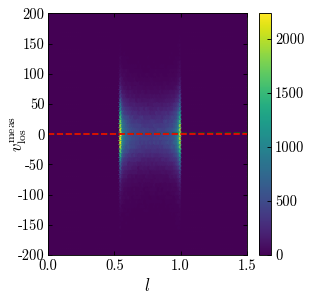

In [14]:
edge1=0
edge2=1.5
hb = plt.hexbin(np.cos((data_train['l']).values),(data_train['radial_velocity']).values,gridsize=100 ,extent=[edge1, edge2, -200, 200])
plt.ylabel(r'$v_{\rm{los}}^{\rm{meas}}$',labelpad=-10)
plt.xlabel(r'$l$')
#,extent=[-200, 200, -200, 200]
x1 = np.linspace(edge1,edge2,1000)
y1 = x1
plt.plot(x1,y1,'g--')
plt.plot(x1,np.zeros_like(x1),'r--')
plt.colorbar()

data_train.loc[data_train.l<0, ['l']] = data_train['l'].apply(lambda x: x*-1)
data_val.loc[data_val.l<0, ['l']] = data_val['l'].apply(lambda x: x*-1)
data_test.loc[data_test.l<0, ['l']] = data_test['l'].apply(lambda x: x*-1)
#data_train['l'] = data_train['l'].apply(lambda x: x*-1)
#data_val['l'] = data_val['l'].apply(lambda x: x*-1)
#data_test['l'] = data_test['l '].apply(lambda x: x*-1)

print(data_train['l'].values)

In [15]:
SS = StandardScaler()
mu = np.mean((data_train['radial_velocity']).values)
stddev = np.std((data_train['radial_velocity']).values)
data_train_scaled = SS.fit_transform(data_train)
data_val_scaled = SS.transform(data_val)
data_test_scaled = SS.transform(data_test)

In [16]:
(2.5 - mu)/stddev

0.07631369439004791

In [17]:
data_train_scaled = pd.DataFrame(data_train_scaled, columns=data_cols)
data_val_scaled = pd.DataFrame(data_val_scaled, columns=data_cols)
data_test_scaled = pd.DataFrame(data_test_scaled, columns=data_cols)

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [19]:
from keras import backend as K
from keras import callbacks as callbacks
global index 
import tensorflow as tf

In [20]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1]) + 1e-6

    LOC = y_pred[:, 0]
    
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.abs(X - LOC) / (2 * K.abs(SIGMA))
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    return K.mean((ARG - PREFACT) * weights)


def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_pred.shape
    y_pred = tf.Variable(y_pred)
    y = tf.constant([0.058])
    y_neg = tf.constant([-0.058])
    indices = tf.where(tf.math.logical_and(tf.math.less_equal(y_pred[:, 0], y),tf.math.greater_equal(y_pred[:, 0], y_neg)))
    indices = tf.reshape(indices,shape = [tf.shape(indices)[0],1])
    updates = tf.zeros_like(indices, dtype=tf.float32)
    mask = tf.ones(shape = [10000,1], dtype=tf.float32)
    #print(tf.tensor_scatter_nd_update(mask, indices, updates))
    mask = tf.tensor_scatter_nd_update(mask, indices, updates)
    y_pred_new = y_pred[:, 0] * mask
    LOC = y_pred_new
    
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.square(X - LOC) / (2.0)
    PREFACT = K.log(K.pow(2 * np.pi, -0.5))
    return K.mean((ARG - PREFACT) * weights)


def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_pred.shape
    output_list = []
    y = tf.constant([0.058])
    y_neg = tf.constant([-0.058])
    #y_pred_list= tf.unstack(y_pred[:,0])
    for step_index in range(10000):
        condition = tf.math.logical_and(tf.math.less_equal(y_pred[step_index, 0], y),tf.math.greater_equal(y_pred[step_index, 0], y_neg))
        def f1(): return tf.multiply(y_pred[step_index, 0] , 0)
        def f2(): return tf.multiply(y_pred[step_index, 0] , 1)
        output_list.append(tf.cond(condition, f1,f2))
    
    y_pred[:, 0] = tf.stack(output_list)
    
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.square(X - LOC) / (2.0)
    PREFACT = K.log(K.pow(2 * np.pi, -0.5))
    return K.mean((ARG - PREFACT) * weights)

def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_pred.shape
    output_list = []
    y = tf.constant([0.058])
    y_neg = tf.constant([-0.058])
    #tensor_shape = [:, 0].get_shape()
    y_pred_list= tf.unstack(y_pred[:,0], axis =0)
    for elem_i in range(len(10000)):
        if ((y_pred_list[elem_i] >= -0.058) and (y_pred_list[elem_i] <= 0.058)):
            y_pred_list[elem_i] = 0
    
    y_pred[:, 0] = tf.stack(y_pred_list, axis =0)
    
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.square(X - LOC) / (2.0)
    PREFACT = K.log(K.pow(2 * np.pi, -0.5))
    return K.mean((ARG - PREFACT) * weights)

In [21]:
def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_pred.shape
    LOC = y_pred[:,0]
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.square(X - LOC) / (2.0)
    PREFACT = K.log(K.pow(2 * np.pi, -0.5))
    return K.mean((ARG - PREFACT) * weights)

# Two network technique to calculate the error

In [22]:
from sklearn.neighbors import NearestNeighbors
from keras.utils import Sequence
from keras.layers import Input, Dense, Lambda, Concatenate, Dropout, Activation, Add
from keras.models import Model
from keras.utils import plot_model
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [23]:
class DataLoader(Sequence):
    
    def __init__(self, 
                 StarDF,  # Dataframe of the stars
                 DistanceVariables,  # column names for the combined distance
                 Features,  # Columns to output for machine learning
                 ToLearn,  # Column to learn
                 NNeighbors,
                 Weights,
                 batch_size=64, shuffle=True):
        'Initialization'
        self.df = StarDF
        self.num_neighbors = NNeighbors
        self.KNN = NearestNeighbors(n_neighbors=NNeighbors,
                                    n_jobs=-1
                                   )
        self.KNN.fit(self.df[DistanceVariables])
        dists, inds = self.KNN.kneighbors(self.df[DistanceVariables])
        self.knn_inds = inds
        self.features = Features
        self.weights = Weights
        self.tolearn = ToLearn
        
        self.indexes = np.arange(len(StarDF))
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
            'Denotes the number of batches per epoch'
            return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        max_ind = np.min([(index+1)*self.batch_size, len(self.df)])
        indexes = self.indexes[index*self.batch_size:max_ind]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, n_features*KNN)
        # Initialization
        Y = self.df[self.tolearn].values[list_IDs_temp]
        data = self.df[self.features].values
        X = data[self.knn_inds[list_IDs_temp]].reshape(len(list_IDs_temp), len(self.features) * self.num_neighbors)
        weights = self.weights[list_IDs_temp]
        Y = np.vstack((Y,weights))
        Y = np.transpose(Y)
        return X, Y

In [24]:
TrainLoader = DataLoader(StarDF=data_train_scaled,
                      DistanceVariables=['x', 'y', 'z'],
                      Features=['l', 'b', 'pmra', 'pmdec', 'parallax'],
                      ToLearn='radial_velocity',
                      NNeighbors=10,
                      Weights = weights_train,
                      batch_size=10000,
                      shuffle = False
                     )
ValLoader = DataLoader(StarDF=data_val_scaled,
                      DistanceVariables=['x', 'y', 'z'],
                      Features=['l', 'b', 'pmra', 'pmdec', 'parallax'],
                      ToLearn='radial_velocity',
                      NNeighbors=10,
                      Weights = weights_val,
                      batch_size=10000,
                      shuffle = False
                     )

TestLoader = DataLoader(StarDF=data_test_scaled,
                      DistanceVariables=['x', 'y', 'z'],
                      Features=['l', 'b', 'pmra', 'pmdec', 'parallax'],
                      ToLearn='radial_velocity',
                      NNeighbors=10,
                      Weights = weights_test,
                      batch_size=10000,
                      shuffle = False
                     )

TrainLoader2 = DataLoader(StarDF=data_train_scaled,
                      DistanceVariables=['x', 'y', 'z'],
                      Features=['l', 'b', 'pmra', 'pmdec', 'parallax'],
                      ToLearn='radial_velocity',
                      NNeighbors=10,
                      Weights = weights_train_2,
                      batch_size=10000,
                      shuffle = False
                     )
ValLoader2 = DataLoader(StarDF=data_val_scaled,
                      DistanceVariables=['x', 'y', 'z'],
                      Features=['l', 'b', 'pmra', 'pmdec', 'parallax'],
                      ToLearn='radial_velocity',
                      NNeighbors=10,
                      Weights = weights_val_2,
                      batch_size=10000,
                      shuffle = False
                     )

In [25]:
x, y = TrainLoader[0]
print(x.shape)
print(y.shape)
print(y[:,0])
print(y[:,1])

(10000, 50)
(10000, 2)
[-0.78153052 -0.59785604 -0.20379622 ...  0.16437933  0.70645974
  0.21777008]
[1.4180741  1.52551197 1.76304405 ... 2.15249546 1.92035269 1.78605797]


10.424070811636627


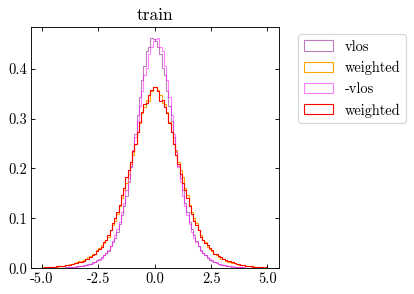

In [26]:
y_low = -5
y_high = 5
bin_num = 100
plt.hist((data_train_scaled['radial_velocity']).values, bins=bin_num, range=(y_low,y_high), histtype='step', edgecolor = 'purple', color= 'skyblue', label = 'vlos', alpha=0.5, density = True)
plt.hist((data_train_scaled['radial_velocity']).values, weights = weights_train, bins=bin_num, range=(y_low,y_high), histtype='step', color= 'orange', label = 'weighted', density = True)
plt.hist(-(data_train_scaled['radial_velocity']).values, bins=bin_num, range=(y_low,y_high), histtype='step', edgecolor = 'magenta', color= 'pink',  label = '-vlos', alpha = 0.5, density = True)
plt.hist(-(data_train_scaled['radial_velocity']).values, weights = weights_train, bins=bin_num, range=(y_low,y_high), histtype='step', color= 'red', label = 'weighted', density = True)
#plt.hist(y[:,0], bins=bin_num, range=(y_low,y_high), histtype='step', color= 'blue',  label = 'unweighted after loader', density = True)
#plt.hist(y[:,0], bins=bin_num, weights = y[:,1], range=(y_low,y_high), histtype='step', color= 'red', label = 'weighed after loader', density = True)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('train')
print(np.max(weights_train))

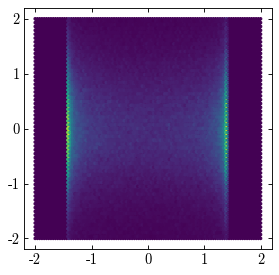

In [27]:
hb = plt.hexbin((data_train_scaled['l']).values,(data_train_scaled['radial_velocity']).values,gridsize=100 ,extent=[-2, 2, -2, 2])






In [28]:
# del(inputs, MeanEst, MeanModel, ConfEst, ConfModel)
input_shape=(TrainLoader[0][0].shape[-1],)
commonInput = Input(input_shape)
MeanEst = Sequential(name="MeanModel")
MeanEst.add(Dense(30, activation='tanh',input_shape=(TrainLoader[0][0].shape[-1],)))
MeanEst.add(Dropout(0.1))
MeanEst.add(Dense(30, activation='tanh'))
MeanEst.add(Dropout(0.1))
MeanEst.add(Dense(30, activation='tanh'))
MeanEst.add(Dropout(0.1))
MeanEst.add(Dense(30, activation='tanh'))
MeanEst.add(Dropout(0.1))
MeanEst.add(Dense(1, activation='linear'))

ConfEst = Sequential(name="ConfModel")
ConfEst.add(Dense(30, activation='tanh',input_shape=(TrainLoader[0][0].shape[-1],)))
ConfEst.add(Dropout(0.1))
ConfEst.add(Dense(30, activation='tanh'))
ConfEst.add(Dropout(0.1))
ConfEst.add(Dense(30, activation='tanh'))
ConfEst.add(Dropout(0.1))
ConfEst.add(Dense(30, activation='tanh'))
ConfEst.add(Dropout(0.1))
ConfEst.add(Dense(1, activation='relu'))

out1 = MeanEst(commonInput)    
out2 = ConfEst(commonInput)    
mergedOut = Concatenate(axis=-1)([out1,out2])
CombinedModel = Model(commonInput, mergedOut)
#plot_model(CombinedModel,to_file='demo.png',show_shapes=True)

In [29]:
#CombinedModel.save_weights('modelsIterate/TrainingBoth_0000.hdf5')

In [30]:
CombinedModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
MeanModel (Sequential)          (None, 1)            4351        input_1[0][0]                    
__________________________________________________________________________________________________
ConfModel (Sequential)          (None, 1)            4351        input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           MeanModel[1][0]                  
                                                                 ConfModel[1][0]            

## First training iteration

In [31]:
CheckPoint = ModelCheckpoint('models_GALAXIA/TrainingMean_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger = CSVLogger(filename='logs/training_mean.log', separator=',', append=False)

mycallbacks = [CheckPoint, ES, RLR, CSV_logger]
#mycallbacks = [ES, RLR]

In [32]:
print(TrainLoader[0][0].shape)

(10000, 50)


In [33]:
ConfEst.trainable = False
MeanEst.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam',
                      
                     )
CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks
                 )

Epoch 1/1000
50/50 [==============================] - 5s 107ms/step - loss: 3.4954 - val_loss: 3.4473
Epoch 2/1000
50/50 [==============================] - 5s 91ms/step - loss: 3.4537 - val_loss: 3.4422
Epoch 3/1000
50/50 [==============================] - 5s 92ms/step - loss: 3.4428 - val_loss: 3.4376
Epoch 4/1000
50/50 [==============================] - 5s 92ms/step - loss: 3.4334 - val_loss: 3.4249
Epoch 5/1000
50/50 [==============================] - 5s 92ms/step - loss: 3.4221 - val_loss: 3.4083
Epoch 6/1000
50/50 [==============================] - 5s 91ms/step - loss: 3.4116 - val_loss: 3.3953
Epoch 7/1000
50/50 [==============================] - 5s 92ms/step - loss: 3.3996 - val_loss: 3.3860
Epoch 8/1000
50/50 [==============================] - 5s 92ms/step - loss: 3.3926 - val_loss: 3.3723
Epoch 9/1000
50/50 [==============================] - 5s 91ms/step - loss: 3.3817 - val_loss: 3.3612
Epoch 10/1000
50/50 [==============================] - 5s 92ms/step - loss: 3.3727 - val_l

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

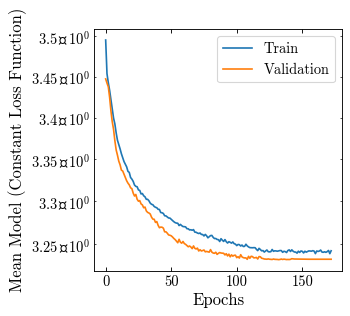

In [34]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [35]:
CheckPoint2 = ModelCheckpoint('models_GALAXIA/TrainingErrorBars_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES2 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR2 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger2 = CSVLogger(filename='logs/training_errorbars.log', separator=',', append=False)

mycallbacks2 = [CheckPoint2, ES2, RLR2, CSV_logger2]
#mycallbacks2 = [ES2, RLR2]

In [36]:
ConfEst.trainable = True
MeanEst.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks2
                 )

Epoch 1/1000
50/50 [==============================] - 5s 105ms/step - loss: 307669.1231 - val_loss: 236678.8281
Epoch 2/1000
50/50 [==============================] - 5s 93ms/step - loss: 195449.3625 - val_loss: 140431.2656
Epoch 3/1000
50/50 [==============================] - 5s 93ms/step - loss: 151847.8337 - val_loss: 139509.1094
Epoch 4/1000
50/50 [==============================] - 5s 93ms/step - loss: 131981.3863 - val_loss: 67019.6719
Epoch 5/1000
50/50 [==============================] - 5s 93ms/step - loss: 103128.8498 - val_loss: 113763.0234
Epoch 6/1000
50/50 [==============================] - 5s 92ms/step - loss: 121288.7812 - val_loss: 103328.2422
Epoch 7/1000
50/50 [==============================] - 5s 93ms/step - loss: 106040.4203 - val_loss: 55513.4609
Epoch 8/1000
50/50 [==============================] - 5s 93ms/step - loss: 63919.8218 - val_loss: 40366.6289
Epoch 9/1000
50/50 [==============================] - 5s 93ms/step - loss: 45237.9885 - val_loss: 1666.1241
Epoch 1

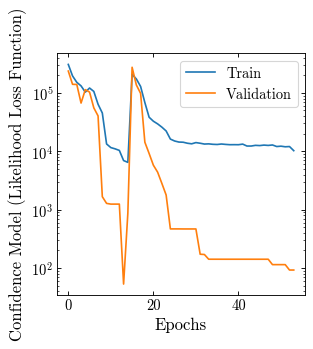

In [37]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Second Training Iteration

In [38]:
CheckPoint4 = ModelCheckpoint('models_GALAXIA/TrainingMean2_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES4 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR4 = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger4 = CSVLogger(filename='logs/training_mean2.log', separator=',', append=False)

mycallbacks4 = [CheckPoint4, ES4, RLR4, CSV_logger4]
#mycallbacks4 = [ES4, RLR4]

In [39]:
ConfEst.trainable = False
MeanEst.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks4
                 )

Epoch 1/1000
50/50 [==============================] - 5s 105ms/step - loss: 3.2449 - val_loss: 3.2328
Epoch 2/1000
50/50 [==============================] - 5s 93ms/step - loss: 3.2420 - val_loss: 3.2327
Epoch 3/1000
50/50 [==============================] - 5s 93ms/step - loss: 3.2430 - val_loss: 3.2329
Epoch 4/1000
50/50 [==============================] - 5s 93ms/step - loss: 3.2433 - val_loss: 3.2321
Epoch 5/1000
50/50 [==============================] - 5s 93ms/step - loss: 3.2412 - val_loss: 3.2346
Epoch 6/1000
50/50 [==============================] - 5s 93ms/step - loss: 3.2424 - val_loss: 3.2316
Epoch 7/1000
50/50 [==============================] - 5s 93ms/step - loss: 3.2431 - val_loss: 3.2333
Epoch 8/1000
50/50 [==============================] - 5s 93ms/step - loss: 3.2424 - val_loss: 3.2341
Epoch 9/1000
50/50 [==============================] - 5s 95ms/step - loss: 3.2403 - val_loss: 3.2324
Epoch 10/1000
50/50 [==============================] - 5s 93ms/step - loss: 3.2411 - val_l

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

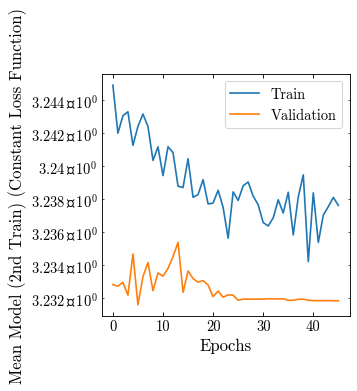

In [40]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (2nd Train) (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [41]:
CheckPoint5 = ModelCheckpoint('models_GALAXIA/TrainingErrorBars2_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES5 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR5 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger5 = CSVLogger(filename='logs/training_errorbars2.log', separator=',', append=False)

mycallbacks5 = [CheckPoint5, ES5, RLR5, CSV_logger5]
#mycallbacks5 = [ES5, RLR5]

In [42]:
ConfEst.trainable = True
MeanEst.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks5
                 )

Epoch 1/1000
50/50 [==============================] - 5s 107ms/step - loss: 1306.0199 - val_loss: 3.1569
Epoch 2/1000
50/50 [==============================] - 5s 96ms/step - loss: 310.7445 - val_loss: 3.1719
Epoch 3/1000
50/50 [==============================] - 5s 95ms/step - loss: 174.5768 - val_loss: 3.1382
Epoch 4/1000
50/50 [==============================] - 5s 95ms/step - loss: 126.8740 - val_loss: 3.1152
Epoch 5/1000
50/50 [==============================] - 5s 95ms/step - loss: 100.6172 - val_loss: 3.2255
Epoch 6/1000
50/50 [==============================] - 5s 95ms/step - loss: 47.9708 - val_loss: 3.1660
Epoch 7/1000
50/50 [==============================] - 5s 95ms/step - loss: 74.7142 - val_loss: 3.1108
Epoch 8/1000
50/50 [==============================] - 5s 94ms/step - loss: 113.8520 - val_loss: 3.1242
Epoch 9/1000
50/50 [==============================] - 5s 94ms/step - loss: 66.3049 - val_loss: 3.0638
Epoch 10/1000
50/50 [==============================] - 5s 94ms/step - loss

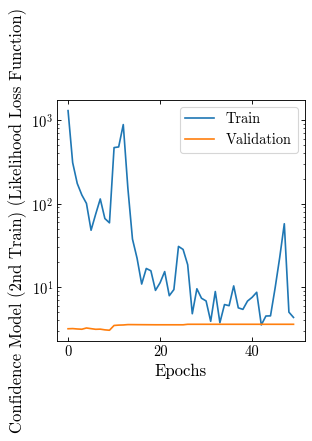

In [43]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (2nd Train) (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Third Training Iteration

In [ ]:
CheckPoint6 = ModelCheckpoint('models_GALAXIA/TrainingMean3_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES4 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR4 = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger6 = CSVLogger(filename='logs/training_mean3.log', separator=',', append=False)

mycallbacks6 = [CheckPoint6, ES4, RLR4, CSV_logger6]
#mycallbacks4 = [ES4, RLR4]

In [ ]:
ConfEst.trainable = False
MeanEst.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks6
                 )

In [ ]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (3rd Train) (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
CheckPoint7 = ModelCheckpoint('models_GALAXIA/TrainingErrorBars3_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES5 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR5 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger7 = CSVLogger(filename='logs/training_errorbars3.log', separator=',', append=False)

mycallbacks7 = [CheckPoint7, ES5, RLR5, CSV_logger7]
#mycallbacks5 = [ES5, RLR5]

In [ ]:
ConfEst.trainable = True
MeanEst.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks7
                 )

In [ ]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (3rd Train) (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Train Both

In [44]:

CheckPoint3 = ModelCheckpoint('models_GALAXIA/TrainingBoth_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES3 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR3 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger3 = CSVLogger(filename='logs/training_both.log', separator=',', append=False)

mycallbacks3 = [CheckPoint3, ES3, RLR3, CSV_logger3]
#mycallbacks3 = [ES3, RLR3]

In [45]:
ConfEst.trainable = True
MeanEst.trainable = True
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit_generator(TrainLoader,
                            validation_data=ValLoader,
                            epochs=1000,
                            callbacks = mycallbacks3
                 )

Epoch 1/1000
50/50 [==============================] - 6s 123ms/step - loss: 100.7307 - val_loss: 2.9802
Epoch 2/1000
50/50 [==============================] - 5s 107ms/step - loss: 40.6341 - val_loss: 2.9733
Epoch 3/1000
50/50 [==============================] - 5s 107ms/step - loss: 38.5066 - val_loss: 2.9207
Epoch 4/1000
50/50 [==============================] - 5s 107ms/step - loss: 44.5973 - val_loss: 2.8379
Epoch 5/1000
50/50 [==============================] - 5s 107ms/step - loss: 44.5270 - val_loss: 2.7754
Epoch 6/1000
50/50 [==============================] - 5s 107ms/step - loss: 124.7610 - val_loss: 2.7245
Epoch 7/1000
50/50 [==============================] - 5s 107ms/step - loss: 86.0416 - val_loss: 2.8857
Epoch 8/1000
50/50 [==============================] - 5s 108ms/step - loss: 85.9922 - val_loss: 2.8416
Epoch 9/1000
50/50 [==============================] - 5s 108ms/step - loss: 67.1698 - val_loss: 2.8724
Epoch 10/1000
50/50 [==============================] - 5s 107ms/step - 

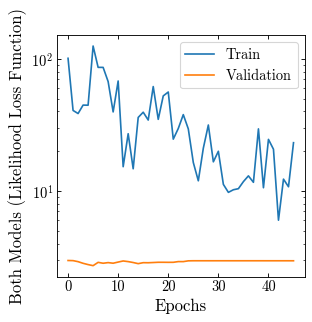

In [46]:
plt.plot(CombinedModel.history.history['loss'])
plt.plot(CombinedModel.history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Both Models (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.savefig('Loss_Plot_Iterate.png')
plt.show()

In [47]:
CombinedModel.save_weights("models_GALAXIA/ModelWeights.h5")

In [ ]:
 def plot_validation(i,type1):   
    y_low = -700
    y_high = 700
    plt.figure(figsize=(12, 12))
    gs0 = gridspec.GridSpec(3, 3, hspace=0.3, wspace=0.3)

    from matplotlib.colors import LogNorm
    plt.subplot(gs0[3])
    plt.hist2d( test_preds[:,1],test_preds[:,0], bins=40,norm = LogNorm())
    clb1 = plt.colorbar()
    clb1.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel('$\sigma$',labelpad=-10)

    plt.subplot(gs0[4])
    sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb2 = plt.colorbar(sc)
    clb2.set_label('$\sigma$', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.clim(0,750)

    plt.subplot(gs0[2])
    hb = plt.hexbin(y_val[:,0], test_preds[:,0],gridsize=80, norm = LogNorm())
    x1 = np.linspace(np.min(y_val[:,0]),np.max(y_val[:,0]),1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb3 = plt.colorbar(hb)
    clb3.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)


    plt.subplot(gs0[5])
    sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb4 = plt.colorbar(sc)
    clb4.set_label('$\sigma$\n(saturated)', labelpad=-25, y=1.15, rotation=0,fontsize=10)
    plt.clim(0,200)

    plt.subplot(gs0[6])
    plt.hist2d(X_val[:,2], test_preds[:,1], bins=40, norm = LogNorm())
    clb5 = plt.colorbar()
    clb5.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.xlabel('Distance',fontsize = 12)
    plt.ylabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[1])
    plotrange = np.linspace(-5,5,1000)
    diff_hist = np.divide(np.subtract(test_preds[:,0],y_val[:,0]),test_preds[:,1])
    mean_diffs, mean_stds = np.mean(diff_hist), np.std(diff_hist)
    plt.hist(diff_hist,bins=20, range=(-5,5), histtype='step',color = 'lightseagreen',linewidth = 1.5, density = True)
    plt.plot(plotrange, norm.pdf(plotrange, mean_diffs, mean_stds),color = 'darkorange', linestyle = '--', linewidth = 2.5,label = 'normal fit')
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 8})
    plt.xlabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})/\sigma$',labelpad=-5)
    
    plt.subplot(gs0[7])
    diff_hist_err = np.subtract(test_preds[:,0],y_val[:,0])
    plt.hist2d(test_preds[:,1],diff_hist_err, bins=40,norm = LogNorm())
    clb6 = plt.colorbar()
    clb6.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})$',labelpad=-5)
    plt.xlabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[0])
    plt.hist(y_val[:,0], bins=25, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'val' )
    plt.hist(test_preds[:,0], bins=25, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
    plt.xlabel(r'$v_{\rm{los}}$', labelpad =-2)
    plt.title('Validation set, Train '+type1+', Epoch '+str(i)+', 20 bins',fontsize=14)
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 10})
    
    plt.savefig('plots'+type1+'/'+'train'+type1+'_'+str(i)+'.png')
    clb1.remove()
    clb2.remove()
    clb3.remove()
    clb4.remove()
    clb5.remove()
    clb6.remove()

#### Plotting First Training

In [ ]:
traininmean = [file for file in os.listdir('models/')
               if file.startswith('TrainingMean_')]
traininmean = sorted(traininmean)[1::10]

In [ ]:
%%capture
for i, mfile in enumerate(traininmean):
    CombinedModel.load_weights('models/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean1');

In [ ]:
traininerror = [file for file in os.listdir('models/')
               if file.startswith('TrainingErrorBars_')]
traininerror = sorted(traininerror)[0::20]

In [ ]:
%%capture
for i_err, mfile_err in enumerate(traininerror):
    CombinedModel.load_weights('models/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error1');

#### Plotting Second Training

In [ ]:
traininmean2 = [file for file in os.listdir('models/')
               if file.startswith('TrainingMean2')]
traininmean2 = sorted(traininmean2)[0::10]

In [ ]:
%%capture
for i, mfile in enumerate(traininmean2):
    CombinedModel.load_weights('models/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean2');

In [ ]:
traininerror2 = [file for file in os.listdir('models/')
               if file.startswith('TrainingErrorBars2')]
traininerror2 = sorted(traininerror2)[0::20]

In [ ]:
%%capture
for i_err, mfile_err in enumerate(traininerror2):
    CombinedModel.load_weights('models/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error2');

#### Plotting Third Training

In [ ]:
traininmean3 = [file for file in os.listdir('models/')
               if file.startswith('TrainingMean3')]
traininmean3 = sorted(traininmean3)[0::10]

In [ ]:
%%capture
for i, mfile in enumerate(traininmean3):
    CombinedModel.load_weights('models/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean3');

In [ ]:
traininerror3 = [file for file in os.listdir('models/')
               if file.startswith('TrainingErrorBars3')]
traininerror3 = sorted(traininerror3)[0::20]

In [ ]:
%%capture
for i_err, mfile_err in enumerate(traininerror3):
    CombinedModel.load_weights('models/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error3');

#### Plot results of training both

In [ ]:
traininboth = [file for file in os.listdir('models/')
               if file.startswith('TrainingBoth')]
traininboth = sorted(traininboth)[1::10]


In [ ]:
%%capture
for i_both, mfile_both in enumerate(traininboth):
    CombinedModel.load_weights('models/' + mfile_both)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_both*10,'Both');

### Evaluate the Test Set

(500000,)
(500000,)
(100,)


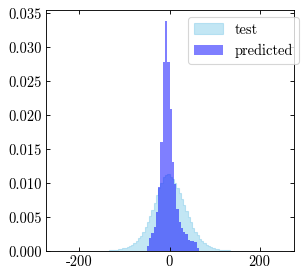

In [48]:
#CombinedModel.load_weights('G_train_2it_nn_500k_tanh_D30_p1dropout_coslb_sigmaleq_0_CORRECT/models_GALAXIA/' + 'ModelWeights.h5')
test_preds_2 = CombinedModel.predict_generator(TestLoader)
y_low = -250
y_high = 250
#here is where I want to rescale test_preds_2[:,0]
test_preds_2[:,0] = (test_preds_2[:,0] * stddev)+mu
test_preds_2[:,1] = (test_preds_2[:,1] * stddev)+mu
#does not work to set = 0 after the fact. 
#for elem_i in range(len(test_preds_2[:,0])):
   # if ((test_preds_2[elem_i,0] >= -10) and (test_preds_2[elem_i,0] <= 10)):
      #  test_preds_2[elem_i, 0] = 0

print(test_preds_2[:,0].shape)
high_err = test_preds_2[:,0] + test_preds_2[:,1]
print(high_err.shape)
low_err = test_preds_2[:,0] - test_preds_2[:,1]
test_preds_hist = np.histogram(test_preds_2[:,0], bins=100, range=(y_low,y_high), density= True)
test_err_hist = np.histogram(test_preds_2[:,1], bins=100, range=(y_low,y_high), density= True)
high_err_hist = np.histogram(high_err, bins=100, range=(y_low,y_high), density= True)
low_err_hist = np.histogram(low_err, bins=100, range=(y_low,y_high), density= True)
conv1 = np.convolve(test_preds_hist[0], high_err_hist[0],'same')
conv2 = np.convolve(high_err_hist[0], low_err_hist[0], 'same')
conv3 = np.convolve(test_preds_hist[0], low_err_hist[0], 'same')
conv4 = np.convolve(test_preds_hist[0],test_err_hist[0],'same')
plt.hist((data_test['radial_velocity']).values, bins=100, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, density = True, label = 'test' , zorder = 0, alpha = 0.5)
#plt.hist(low_err, bins=100, range=(y_low,y_high), density= True, alpha = 0.5)
#plt.hist(high_err, bins=100, range=(y_low,y_high), density= True,alpha = 0.5)
plt.hist(test_preds_2[:,0], bins=100, range=(y_low,y_high), density= True,alpha = 0.5, color = 'blue', label = 'predicted')
#plt.hist(test_preds_2[:,1], bins=100, range=(0,100), density= True)
#plt.figure()
#plt.plot(conv2, label = 'conv2')
#plt.plot(conv1,label = 'conv1')
#plt.plot(conv3,label = 'conv3')
#plt.plot(conv4,label = 'conv4')
#perhpas conv 2 gives errors on histogram bins
plt.legend(bbox_to_anchor=(1.05, 1))
print(conv1.shape)

In [ ]:
plt.figure()
plt.hist((data_test['radial_velocity']).values, bins=100, range=(y_low,y_high), histtype='step', color= 'blue', label = 'test', density = True, alpha = 0.5)
num, binss, _ = plt.hist(test_preds_2[:,0], bins=100, range=(y_low,y_high), histtype='step',color = 'green',  label = 'predicted', density = True, alpha = 0.5)
mid = 0.5*(binss[1:] + binss[:-1])
print(mid.shape)
#plt.errorbar(mid, num,yerr = conv2, fmt='.',color = 'blue', label = 'predicted')
plt.fill_between(mid[0:50],num[0:50]-conv3[0:50],num[0:50]+conv3[0:50] ,label = 'error from conv',color = 'red', zorder = 10, alpha = 0.5)
plt.fill_between(mid[49:100],num[49:100]-conv1[49:100],num[49:100]+conv1[49:100] ,color = 'red', zorder = 10, alpha = 0.5)

#plt.fill_between(mid,num-conv1,num+conv1 ,label = 'error',color = 'red', zorder = 10, alpha = 0.5)
#capsize=3
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
#plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [66]:
#going to consider low error points those with error <= 50 km/s
#test_preds_70 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=70)[0], 0)
#print(test_preds_70.shape)
test_preds_50 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=50)[0], 0)
print(test_preds_50.shape)
test_preds_45 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=45)[0], 0)
print(test_preds_45.shape)
test_preds_40 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=40)[0], 0)
print(test_preds_40.shape)
test_preds_35 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=35)[0], 0)
print(test_preds_35.shape)
test_preds_25 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=25)[0], 0)
print(test_preds_25.shape)
test_preds_18 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=18)[0], 0)
print(test_preds_18.shape)
test_preds_22 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=22)[0], 0)
print(test_preds_22.shape)

(6441, 2)
(2492, 2)
(847, 2)
(263, 2)
(14, 2)
(1, 2)
(2, 2)


In [50]:
save_indices(22)

less
134378


In [62]:
thresholds = [50]
for thresh_i in thresholds: 
    save_indices(thresh_i)

less
6441


## Going to use Monte Carlo simulations to predict errorbars. 

In [49]:
def monte_carlo(test_preds_cut, thresh):  
    from matplotlib.colors import LogNorm
    mc_vr_pred_list = []
    bin_values_list = []
    min_array = []
    max_array = []
    mean_array = []
    data_test = reload_data_per_cut(thresh)
    hb_list = []
    hex_centers = []
    for mc_i in range(0,100):
        mc_vr_pred = []
        for star_i in range(0,len(test_preds_cut)):
            #mc_vr_pred.append(np.mean([np.random.normal(test_preds_2[star_i,0],test_preds_2[star_i,1]) for _ in range(1000)]))
            mc_vr_pred.append(np.random.normal(test_preds_cut[star_i,0],test_preds_cut[star_i,1]))
        mc_vr_pred_list.append(mc_vr_pred)
        n, bins = np.histogram(mc_vr_pred, bins=100, range=(y_low,y_high))
        #plt.xlabel('Vr Monte Carlo')
        plt.figure(2)
        hb = plt.hexbin((data_test['radial_velocity']).values, mc_vr_pred,gridsize=100, norm = LogNorm(),extent=[-200, 200, -200, 200]);
        plt.close(2)
        hb_list.append(hb.get_array());
        #print(np.shape(hb.get_array()))
        #plt.yscale('log')
        bin_values_list.append(n)
        
    bin_values_list_arr = np.array(bin_values_list)    
    max_array = bin_values_list_arr.max(axis=0)
    min_array = bin_values_list_arr.min(axis=0) 
    mean_array = bin_values_list_arr.mean(axis=0)
    y_error = [min_array,max_array]
    print(np.shape(y_error))
    

    return min_array, max_array, hb_list

In [50]:
def reload_data_per_cut(thresh):
    hold = 0
    data_test = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/test_set_500k.npz')
    data_test = data_test['data']
    data_cols = ['source_id', 'l', 'b', 'ra', 'dec', 'parallax', 'parallax_error', 
                 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity',
                 'photo_g_mean_mag', 'photo_bp_mean_mag', 'photo_rp_mean_mag',
                 'x','y','z','vx','vy','vz','r','phi','theta','vr','vphi','vtheta']
    data_test = pd.DataFrame(data_test, columns=data_cols)
    print(data_test.shape)
    indices_to_drop = []
    if thresh >= 80:
        indices_to_drop = np.load('data_indices_error_gt_'+str(thresh)+'.npy')
        print(np.shape(indices_to_drop))
        print('number of indices left '+ str(500000-np.shape(indices_to_drop)[0]))
        print(indices_to_drop[332788:332798])
        indices_to_drop = np.array(indices_to_drop)
        print(indices_to_drop[0:1000])
        print([item for item, count in collections.Counter(indices_to_drop).items() if count > 1])
        #data_test = data_test.loc[indices_to_drop]
        data_test = data_test.drop(data_test.index[indices_to_drop])
        print(data_test.shape)
    elif thresh < 80 and thresh > 0:
        indices_to_drop = np.load('data_indices_error_lt_'+str(thresh)+'.npy')
        print(np.shape(indices_to_drop))
        print(indices_to_drop[1:10])
        data_test = data_test.loc[indices_to_drop]
        #data_test = data_test.drop(data_test.index[indices_to_drop])
        print('second if '+str(data_test.shape))
    elif thresh == 0: 
        hold = 0
        print('hold = 0')

    #pdiff_test = float(len(np.argwhere((data_test['radial_velocity']).values < 0))/len(np.argwhere((data_test['radial_velocity']).values > 0)))
    #if pdiff_test > 1: data_test.drop(data_test.query('radial_velocity < 0').sample(frac=(pdiff_test-1)).index, inplace = True)
    #pdiffafter_test = float(len(np.argwhere((data_test['radial_velocity']).values < 0))/len(np.argwhere((data_test['radial_velocity']).values > 0)))
    weights_test = np.ones(data_test.shape[0])
    return data_test

plt.figure()
hist_test, bins_test, patches_test = plt.hist((data_test['radial_velocity']).values, bins=100, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test' , zorder = 0)
#plt.hist(bins_test[:-1], bins_test, weights=max_array,color = 'green')
#plt.hist(bins_test[:-1], bins_test, weights=min_array,color = 'yellow')
bin_centers_test = (bins_test[1:]+bins_test[:-1])/2
plt.fill_between(bin_centers_test,min_array, max_array,label = 'MC spread',color = 'orange', zorder = 10, alpha = 0.5)
plt.hist(test_preds_2_save[:,0], bins=100, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted', zorder = 20)

print(y_low,y_high)
plt.xlabel(r'$v_{\rm{los}}$')
plt.title('Test set, $\sigma \leq$40 km/s')
#plt.yscale('log')
plt.legend(loc = "upper right",prop={'size': 10})
#plt.savefig('MC_100trials_500k_sigmalt40_try2.png')
plt.show()

In [51]:
 def plot_test(thresh): 
    data_test = reload_data_per_cut(thresh)
    print('shape of data_test is '+str(data_test.shape))
    if thresh == 0: test_preds = test_preds_2
    elif thresh == 50: test_preds = test_preds_50
    elif thresh == 45: test_preds = test_preds_45
    elif thresh == 40: test_preds = test_preds_40
    elif thresh == 30: test_preds = test_preds_30
    elif thresh == 35: test_preds = test_preds_35
    elif thresh == 25: test_preds = test_preds_25
    elif thresh == 20: test_preds = test_preds_20
    elif thresh == 22: test_preds = test_preds_22
    elif thresh == 18: test_preds = test_preds_18
    y_low = -250
    y_high = 250
    plt.figure(figsize=(12, 12))
    gs0 = gridspec.GridSpec(3, 3, hspace=0.3, wspace=0.3)

    from matplotlib.colors import LogNorm
    plt.subplot(gs0[3])
    plt.hist2d(test_preds[:,1],test_preds[:,0], bins=40,norm = LogNorm())
    clb1 = plt.colorbar()
    clb1.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel('$\sigma$',labelpad=-5)
    

    plt.subplot(gs0[2])
    hb = plt.hexbin((data_test['radial_velocity']).values, test_preds[:,0],gridsize=100, norm = LogNorm(),extent=[-200, 200, -200, 200])
    #x1 = np.linspace(np.min((data_test_scaled['radial_velocity']).values),np.max((data_test_scaled['radial_velocity']).values),1000)
    x1 = np.linspace(-150,150,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb3 = plt.colorbar(hb)
    clb3.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)


    plt.subplot(gs0[5])
    plt.hist2d((data_test['l']).values,test_preds[:,0], bins=40,norm = LogNorm())
    clb4 = plt.colorbar()
    clb4.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.plot(x1,y1,'k--')
    plt.xlabel(r'$l$',labelpad=-3)
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-5)


    plt.subplot(gs0[6])
    dist_hist = np.divide(np.ones_like((data_test['parallax']).values),(data_test['parallax']).values)
    plt.hist2d(dist_hist, test_preds[:,1], bins=40, norm = LogNorm())
    clb5 = plt.colorbar()
    clb5.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.xlabel('Distance (kpc)',fontsize = 12)
    plt.ylabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[1])
    plotrange = np.linspace(-5,5,1000)
    diff_hist = np.divide(np.subtract(test_preds[:,0],(data_test['radial_velocity']).values),test_preds[:,1])
    mean_diffs, mean_stds = np.mean(diff_hist), np.std(diff_hist)
    plt.hist(diff_hist,bins=20, range=(-5,5), histtype='step',color = 'lightseagreen',linewidth = 1.5, density = True)
    plt.plot(plotrange, norm.pdf(plotrange, mean_diffs, mean_stds),color = 'darkorange', linestyle = '--', linewidth = 2.5,label = 'normal fit')
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 8})
    plt.xlabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})/\sigma$',labelpad=-5)
    
    plt.subplot(gs0[4])
    plt.hist2d((data_test['l']).values,test_preds[:,1], bins=40,norm = LogNorm())
    clb2 = plt.colorbar()
    clb2.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.plot(x1,y1,'k--')
    plt.xlabel(r'$l$',labelpad=-3)
    plt.ylabel('$\sigma$',labelpad=-5)
    

    plt.subplot(gs0[0])
    plt.hist((data_test['radial_velocity']).values, bins=100, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test', density = True )
    plt.hist(test_preds[:,0], bins=100, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted', density = True)
    plt.xlabel(r'$v_{\rm{los}}$', labelpad =-2)
    if thresh == 0: plt.title('Test set, 100 bins, no sigma cut',fontsize=14)
    if thresh != 0: plt.title('Test set, $\sigma \leq$'+str(thresh)+' km/s',fontsize=14)
    #plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 10})
    
    
    plt.subplot(gs0[7])
    hist_test, bins_test, patches_test = plt.hist((data_test['radial_velocity']).values, bins=100, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'test' , zorder = 0)
    bin_centers_test = (bins_test[1:]+bins_test[:-1])/2
    min_array, max_array, hb_list = monte_carlo(test_preds, thresh);
    plt.fill_between(bin_centers_test,min_array, max_array,label = 'MC spread',color = 'orange', zorder = 10, alpha = 0.5)
    plt.hist(test_preds[:,0], bins=100, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted', zorder = 20)
    plt.xlabel(r'$v_{\rm{los}}$')
    plt.legend(loc = "upper right",prop={'size': 10})
    
    plt.subplot(gs0[8])
    hb_mean=plt.hexbin((data_test['radial_velocity']).values, np.zeros_like((data_test['radial_velocity']).values), gridsize=100, norm = LogNorm(),extent=[-200, 200, -200, 200])
    hb_mean.set_array(np.mean(hb_list, axis = 0))
#     offsets = hb_mean.get_offsets()
#     x = offsets[:,0]
#     y = offsets[:,1]
#     z = np.mean(hb_list, axis = 0)
#     contour(np.mean(hb_list, axis = 0).reshape(,extent=[x.min(),x.max(),y.min(),y.max()],linewidths=3)
    
    x1 = np.linspace(-150,150,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred, MC}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    plt.clim(1,(np.max(hb_list)/2)*1.5)
    clb6 = plt.colorbar(hb_mean)
    clb6.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    
    plt.savefig('plots_test_2it_nn_500k_tanh_D30_p1dropout_cosl_log2dweights_sigmaleq_'+str(thresh)+'.png')
    clb1.remove()
    clb2.remove()
    clb3.remove()
    clb4.remove()
    clb5.remove()
    clb6.remove()

(500000, 27)
hold = 0
shape of data_test is (500000, 27)
(500000, 27)
hold = 0
(2, 100)


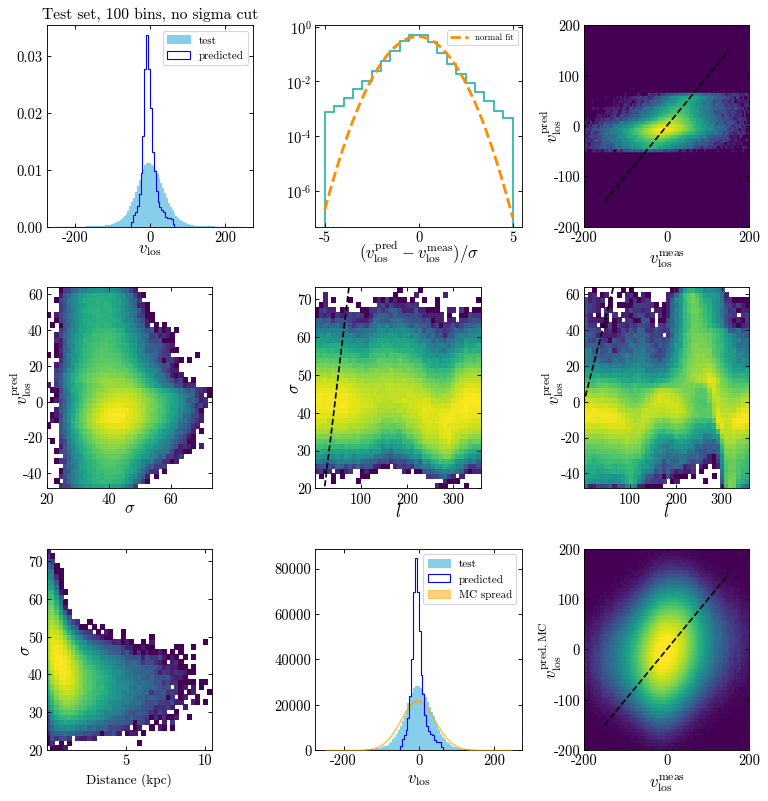

In [52]:
plot_test(0)

In [65]:
plot_test(50)

(500000, 27)
(6441,)
[ 224  247  348  442  585  986 1111 1168 1171]
second if (6441, 27)
shape of data_test is (6441, 27)


NameError: name 'test_preds_50' is not defined

(500000, 27)
(6441,)
[ 224  247  348  442  585  986 1111 1168 1171]
second if (6441, 27)
shape of data_test is (6441, 27)
(500000, 27)
(6441,)
[ 224  247  348  442  585  986 1111 1168 1171]
second if (6441, 27)
(2, 100)


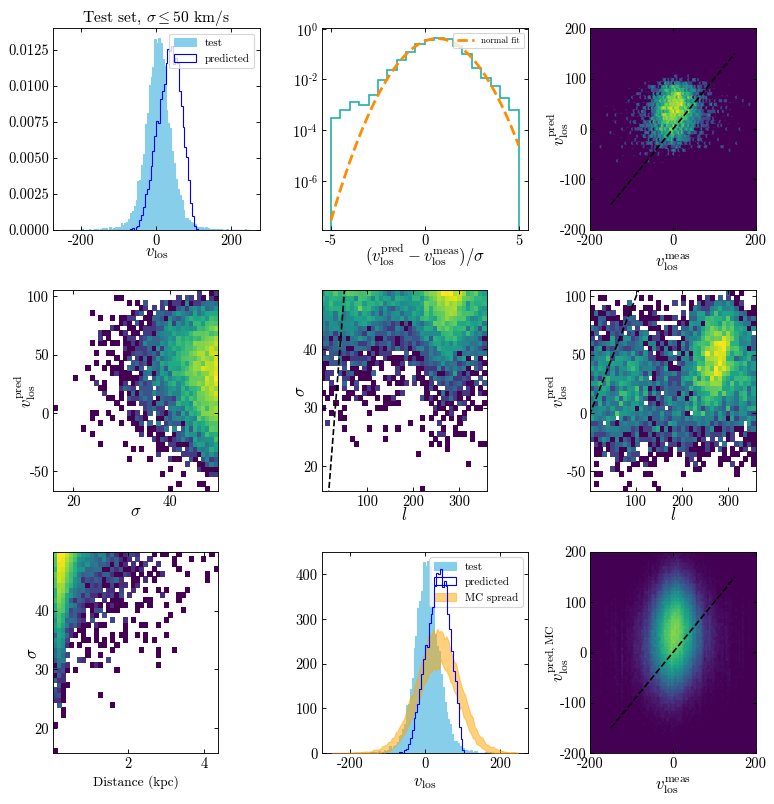

In [67]:
plot_test(50)

In [ ]:
plot_test(0)

(500000, 27)
hold = 0
shape of data_test is (500000, 27)
(500000, 27)
hold = 0
(2, 100)


##### Going to try to find original indices of points with low error in train, validation, and test & retrain without those

In [61]:
def save_indices(thresh):
    if thresh >= 80:
        list_err_gt = []   
        list_err_gt = [(data_test['radial_velocity']).values[i] for i in range(len(test_preds_2[:,1])) if test_preds_2[i,1] > thresh]
        print(len(list_err_gt))
        #now need indices of these values in data
        indices = []
        for i in range(len(list_err_gt)):
            indices.append(data_test[data_test['radial_velocity']==(list_err_gt[i])].index[0])
        np.save('data_indices_error_gt_'+str(thresh),indices)
    else:
        print('less')
        list_err_lt = []   
        list_err_lt = [(data_test['radial_velocity']).values[i] for i in range(len(test_preds_2[:,1])) if test_preds_2[i,1] < thresh]
        print(len(list_err_lt))
        #now need indices of these values in data
        indices = []
        for i in range(len(list_err_lt)):
            indices.append(data_test[data_test['radial_velocity']==(list_err_lt[i])].index[0])
        np.save('data_indices_error_lt_'+str(thresh),indices)
        

In [ ]:
CombinedModel.load_weights('models/' + 'TrainingBoth_0138.hdf5')
test_preds_train = CombinedModel.predict(X_train)

list_rv_train_err_lt65 = [y_train[i,0] for i in range(len(test_preds_train[:,1])) if test_preds_train[i,1] < 90]
for i in range(len(list_rv_train_err_lt65)):
    indices.append(data[data['radial_velocity']==(list_rv_train_err_lt65[i])].index[0])

In [ ]:
test_preds_val = CombinedModel.predict(X_val)

list_rv_val_err_lt65 = [y_val[i,0] for i in range(len(test_preds_val[:,1])) if test_preds_val[i,1] < 90]
for i in range(len(list_rv_val_err_lt65)):
    indices.append(data[data['radial_velocity']==(list_rv_val_err_lt65[i])].index[0])